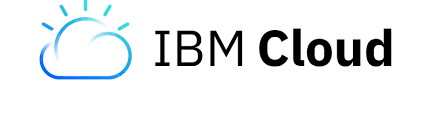

## CASE STUDY - Deploying a recommender

For this lab we will be using the MovieLens data :

* [MovieLens Downloads](https://grouplens.org/datasets/movielens/latest/)

download either **ml-latest-small.zip** or **ml-latest.zip** from this link and add the unziped folder to the data folder of the lab directory. We recommend you to use the small version if you are not working with a Spark cluster or a High memory machine.

The two important pages for documentation are below.

* [Spark MLlib collaborative filtering docs](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) 
* [Spark ALS docs](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS)


In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import pyspark as ps
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.types import DoubleType

DATA_DIR = os.path.join("..", "data")
SAVE_DIR = os.path.join("..", "saved-recommender")

if os.path.isdir(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)

In [2]:
## ensure the spark context is available
spark = (ps.sql.SparkSession.builder
        .appName("sandbox")
        .getOrCreate()
        )

sc = spark.sparkContext
print(spark.version) 

3.0.0


### Ensure the data are downloaded, unziped and placed in the data folder of this lab.

In [3]:
movielens_data_dir = os.path.join(DATA_DIR, "ml-latest-small")        
if not os.path.exists(movielens_data_dir):
    print("ERROR make sure the path to the Movie Lens data is correct")

In [4]:
## load the ratings data as a pysaprk dataframe
ratings_file = os.path.join(movielens_data_dir, "ratings.csv")
df = spark.read.format("csv").options(header="true", inferSchema="true").load(ratings_file)
df = df.withColumnRenamed("movieID", "movie_id")
df = df.withColumnRenamed("userID", "user_id")
df.show(n=4)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|       1|   4.0|964982703|
|      1|       3|   4.0|964981247|
|      1|       6|   4.0|964982224|
|      1|      47|   5.0|964983815|
+-------+--------+------+---------+
only showing top 4 rows



In [5]:
## load the movies data as a pyspark dataframe
movies_file = os.path.join(movielens_data_dir, "movies.csv") 
movies_df = spark.read.format("csv").options(header="true", inferSchema="true").load(movies_file)
movies_df = movies_df.withColumnRenamed("movieID", "movie_id")
movies_df.show(n=4)


+--------+--------------------+--------------------+
|movie_id|               title|              genres|
+--------+--------------------+--------------------+
|       1|    Toy Story (1995)|Adventure|Animati...|
|       2|      Jumanji (1995)|Adventure|Childre...|
|       3|Grumpier Old Men ...|      Comedy|Romance|
|       4|Waiting to Exhale...|Comedy|Drama|Romance|
+--------+--------------------+--------------------+
only showing top 4 rows



## QUESTION 1

Explore the movie lens data a little and summarize it.

In [6]:
## YOUR CODE HERE (summarize the data)
df.describe().show()
print('Unique users: {}'.format(df.select('user_id').distinct().count()))
print('Unique movies: {}'.format(df.select('movie_id').distinct().count()))
print('Movies with Rating > 2: {}'.format(df.filter('rating > 2').select('movie_id').distinct().count()))
print('Movies with Rating > 3: {}'.format(df.filter('rating > 3').select('movie_id').distinct().count()))
print('Movies with Rating > 4: {}'.format(df.filter('rating > 4').select('movie_id').distinct().count()))

+-------+------------------+----------------+------------------+--------------------+
|summary|           user_id|        movie_id|            rating|           timestamp|
+-------+------------------+----------------+------------------+--------------------+
|  count|            100836|          100836|            100836|              100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|1.2059460873684695E9|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|2.1626103599513078E8|
|    min|                 1|               1|               0.5|           828124615|
|    max|               610|          193609|               5.0|          1537799250|
+-------+------------------+----------------+------------------+--------------------+

Unique users: 610
Unique movies: 9724
Movies with Rating > 2: 8852
Movies with Rating > 3: 7363
Movies with Rating > 4: 4056


## QUESTION 2

Find the ten most popular movies. 


1. Create 2 pyspark dataframes one with the count of each film in df and one with the average rating of each movie in df.
2. Join these two dataframes in a third dataframe. Then, filter this dataframe to select only the movies that have been seen more than 100 times.
3. Use the movies_df dataframe to add the names of each movies on the dataframe created in 2. Then, order the dataframe by descending average rating.



In [7]:
## YOUR CODE HERE (Replace the symbole #<> with your code)

## 1_
movie_counts = df.groupBy("movie_id").count()
top_rated = df.groupBy("movie_id").avg('rating')

## 2_
top_movies = top_rated.join(movie_counts, on='movie_id').filter('count>100')

## 3_
top_movies = top_movies.join(movies_df, on='movie_id').orderBy('avg(rating)', ascending=False)


top_movies.show(10)

+--------+-----------------+-----+--------------------+--------------------+
|movie_id|      avg(rating)|count|               title|              genres|
+--------+-----------------+-----+--------------------+--------------------+
|     318|4.429022082018927|  317|Shawshank Redempt...|         Crime|Drama|
|     858|        4.2890625|  192|Godfather, The (1...|         Crime|Drama|
|    2959|4.272935779816514|  218|   Fight Club (1999)|Action|Crime|Dram...|
|    1221| 4.25968992248062|  129|Godfather: Part I...|         Crime|Drama|
|   48516|4.252336448598131|  107|Departed, The (2006)|Crime|Drama|Thriller|
|    1213|             4.25|  126|   Goodfellas (1990)|         Crime|Drama|
|   58559|4.238255033557047|  149|Dark Knight, The ...|Action|Crime|Dram...|
|      50|4.237745098039215|  204|Usual Suspects, T...|Crime|Mystery|Thr...|
|    1197|4.232394366197183|  142|Princess Bride, T...|Action|Adventure|...|
|     260|4.231075697211155|  251|Star Wars: Episod...|Action|Adventure|...|

## QUESTION 3

We will now fit a ALS model, this is matrix factorization model used for rating recommendation. See the [Spark ALS docs](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.recommendation.ALS)
for example usage. 

First we split the data

In [8]:
(training, test) = df.randomSplit([0.8, 0.2])

Create a function called **train_model()** that takes two inputs :

1. ``reg_param`` : the regularization parameter of the factorization model
2. ``implicit_prefs`` : a boolean variable that indicate whereas the model should used explicit or implicit ratings.
    
The function train an ALS model on the training set then predict the test set and evaluate this prediction.
The output of the function should be the RMSE of the fitted model on the test set./

In [9]:
## YOUR CODE HERE (Replace the symbole #<> with your code)

def train_model(reg_param, implicit_prefs=False):
    """
    Train and evaluate an ALS model
    Inputs : the regularization parametre of the ALS model and the implicit_prefs flag
    Ouptus : a string with the RMSE and the regularization parameter inputed
    """
    
    als = ALS(maxIter=5, regParam=reg_param, userCol="user_id", 
              itemCol="movie_id", ratingCol="rating",
              coldStartStrategy="drop", implicitPrefs=implicit_prefs)
    model = als.fit(training)

    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")

    rmse = evaluator.evaluate(predictions)
    print("regParam={}, RMSE={}".format(reg_param, np.round(rmse, 2)))


Calling the function created above for several ``reg_param`` values find the best regularization parameter.

In [10]:
for reg_param in [0.01, 0.05, 0.1, 0.15, 0.25]:
    train_model(reg_param)

regParam=0.01, RMSE=1.11
regParam=0.05, RMSE=0.95
regParam=0.1, RMSE=0.88
regParam=0.15, RMSE=0.87
regParam=0.25, RMSE=0.9


## QUESTION 4

With your best regParam try using the `implicitPrefs` flag.

>Note that the results here make sense because the data are `explicit` ratings

In [11]:
## YOUR CODE HERE

train_model(0.1, implicit_prefs=True)

regParam=0.1, RMSE=3.24


## QUESTION 5

Retrain the model with your best ``reg_param`` and ``implicit_prefs`` on the entire dataset and save the trained model in the SAVE_DIR directory.

In [12]:
## YOUR CODE HERE (Replace the symbole #<> with your code)

## re-train using the whole data set
print("...training")
als = ALS(maxIter=5, regParam=0.1, userCol="user_id", 
          itemCol="movie_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(df)
    
## save model
print("...saving als model")
model.save(SAVE_DIR)
print("done.")

...training
...saving als model
done.


## QUESTION 6

We now want to use ``spark-submit`` to load the model and demonstrate that you can load the model and interface with it.

Following the best practices we created a python script (``recommender-submit.py``) in the **scripts** folder that loads the model, creates some hand crafted data points and query the model. We recommend you to go over this script and make sure you understand it before running it through this notebook.

In [13]:
! python ../scripts/recommender-submit.py

20/09/15 21:07:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
20/09/15 21:07:59 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
best rated [(260,), (2628,), (1196,), (122886,), (187595,), (179819,), (1210,)]
20/09/15 21:08:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
20/09/15 21:08:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
closest_users                                                                   
 [(53,), (452,), (93,), (267,), (515,), (30,), (97,), (371,), (475,), (122,), (276,), (25,), (52,), (456,), (12,), (523,), (389,), (80,), (246,), (540,), (319,), (119,), (106,)